In [1]:
import warnings
warnings.simplefilter('ignore')

In [55]:
import numpy as np
import pandas as pd
import warnings
from pandas_profiling import ProfileReport
from fast_ml.feature_selection import get_constant_features
import seaborn as sns
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import lightgbm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle


warnings.simplefilter('ignore')
%matplotlib inline

In [46]:
df = pd.read_csv('HousingData.csv')
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1,296,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2,242,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2,242,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3,222,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3,222,18.70,396.90,NaN,36.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06,0.00,11.93,0.00,0.57,6.59,69.10,2.48,1,273,21.00,391.99,NaN,22.40
502,0.05,0.00,11.93,0.00,0.57,6.12,76.70,2.29,1,273,21.00,396.90,9.08,20.60
503,0.06,0.00,11.93,0.00,0.57,6.98,91.00,2.17,1,273,21.00,396.90,5.64,23.90
504,0.11,0.00,11.93,0.00,0.57,6.79,89.30,2.39,1,273,21.00,393.45,6.48,22.00


In [47]:
df.rename(columns = {'MEDV':'Price'}, inplace = True)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1,296,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2,242,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2,242,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3,222,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3,222,18.70,396.90,NaN,36.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06,0.00,11.93,0.00,0.57,6.59,69.10,2.48,1,273,21.00,391.99,NaN,22.40
502,0.05,0.00,11.93,0.00,0.57,6.12,76.70,2.29,1,273,21.00,396.90,9.08,20.60
503,0.06,0.00,11.93,0.00,0.57,6.98,91.00,2.17,1,273,21.00,396.90,5.64,23.90
504,0.11,0.00,11.93,0.00,0.57,6.79,89.30,2.39,1,273,21.00,393.45,6.48,22.00


In [5]:
profile = ProfileReport(df) 
profile.to_file('profile.html')

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Handling Missing Values

In [48]:
df['CRIM'] = df['CRIM'].fillna(df['CRIM'].median())
df['ZN'] = df['ZN'].fillna(df['ZN'].median())
df['INDUS'] = df['INDUS'].fillna(df['INDUS'].median())
df['CHAS'] = df['CHAS'].fillna(df['CHAS'].median())
df['AGE'] = df['AGE'].fillna(df['AGE'].median())
df['LSTAT'] = df['LSTAT'].fillna(df['LSTAT'].median())

In [15]:
df['CRIM'].median()

0.253715

In [49]:
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
Price      0
dtype: int64

# Checking for duplicate rows and columns

In [6]:
df.duplicated().sum() #obvious from profile report

0

In [7]:
df.T.duplicated().sum() #obvious from profile report

0

# Checking constant and Quasi-Constant features

#### Constant -  only one value in the feature
#### Quasi-Constant - same value for a great majority in feature

In [8]:
get_constant_features(df)

,Desc,Var,Value,Perc


# Handling Outliers

### can remove outliers but this method will include median imputation

In [9]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'Price'],
      dtype='object')

In [32]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.48,10.77,11.03,0.07,0.55,6.28,68.85,3.80,9.55,408.24,18.46,356.67,12.66,22.53
std,8.57,23.03,6.70,0.25,0.12,0.70,27.49,2.11,8.71,168.54,2.16,91.29,7.02,9.20
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.92,2.10,4.00,279.00,17.40,375.38,7.23,17.02
50%,0.25,0.00,9.69,0.00,0.54,6.21,76.80,3.21,5.00,330.00,19.05,391.44,11.43,21.20
75%,2.81,0.00,18.10,0.00,0.62,6.62,93.57,5.19,24.00,666.00,20.20,396.23,16.57,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


In [35]:
df['ZN'].unique()

array([ 18. ,   0. ,  12.5,  75. ,  21. ,  90. ,  85. , 100. ,  25. ,
        17.5,  80. ,  28. ,  45. ,  60. ,  95. ,  82.5,  30. ,  22. ,
        20. ,  40. ,  55. ,  52.5,  70. ,  34. ,  33. ,  35. ])

In [37]:
dfc = df.copy()

<AxesSubplot:>

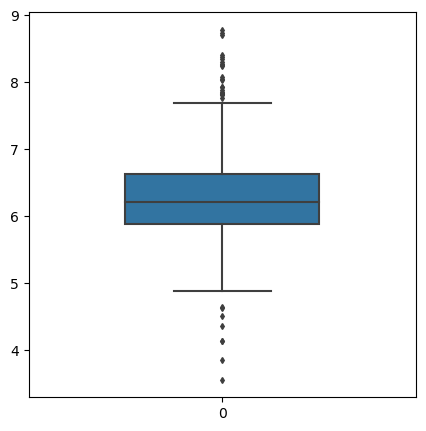

In [52]:
plt.subplots(figsize=(5,5))
sns.boxplot(data = dfc['RM'], width = 0.5,fliersize = 3)

<AxesSubplot:>

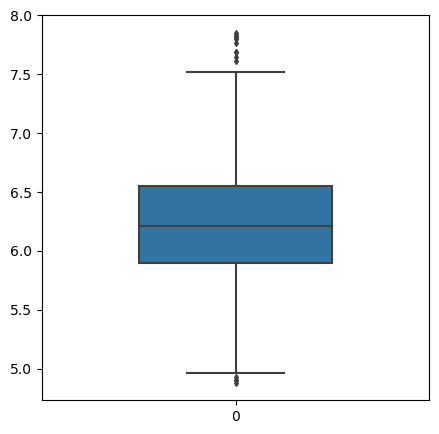

In [53]:
plt.subplots(figsize=(5,5))
sns.boxplot(data = df['RM'], width = 0.5,fliersize = 3)

In [11]:
df['LSTAT'].quantile(0.98)

30.617

In [50]:
# for median imputation

def impute(column,quant1, quant2): #quant1 for lower fence; quant2 for upper fence
    if quant1 is 0.0:
        # considering upper fence
        quantile_value_ufence = column.quantile(quant2)
        for val in column:
            if val < quantile_value_ufence:
                column.replace(val,column.median(), inplace=True)
    
    if quant2 is 0.0:
        # considering lower fence
        quantile_value_lfence = column.quantile(quant1)
        for val in column:
            if val > quantile_value_lfence:
                column.replace(val,column.median(), inplace=True)
                
    else:
        quantile_value_ufence = column.quantile(quant2)
        quantile_value_lfence = column.quantile(quant1)
        for val in column:
            if val > quantile_value_ufence or val < quantile_value_lfence:
                column.replace(val,column.median(), inplace=True)

In [51]:
impute(df['CRIM'],0.0,0.9) # upper

impute(df['ZN'],0.0,0.87) # upper

impute(df['RM'],0.015, 0.97) # lower and upper

impute(df['DIS'],0.0,0.99) # upper

impute(df['PTRATIO'],0.01,0.0) # lower

impute(df['B'],0.16,0.0) #lower

impute(df['LSTAT'],0.0,0.98) # upper

# FEATURE SELECTION

In [58]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

### 1. Information Gain

In [15]:
df.shape

(506, 14)

In [16]:
importance = mutual_info_regression(X,y)

In [17]:
sample_df = pd.Series(importance, index = X.columns)
sample_df.nlargest(5)

LSTAT   0.60
NOX     0.47
RM      0.47
INDUS   0.43
TAX     0.35
dtype: float64

## Top 5 important features (according to information gain) are - 

1. LSTAT   
2. RM      
3. NOX     
4. INDUS
5. TAX 

### 2. ExtraTrees 

In [18]:
ext = ExtraTreesRegressor()
ext.fit(X,y)
ext.feature_importances_

array([4.21454760e-02, 1.33660400e-02, 6.59574063e-02, 1.90429246e-02,
       6.07866142e-02, 1.84134624e-01, 2.63606037e-02, 4.29548017e-02,
       3.20124780e-02, 5.91697219e-02, 0.00000000e+00, 4.08182950e-04,
       4.53661127e-01])

<AxesSubplot:>

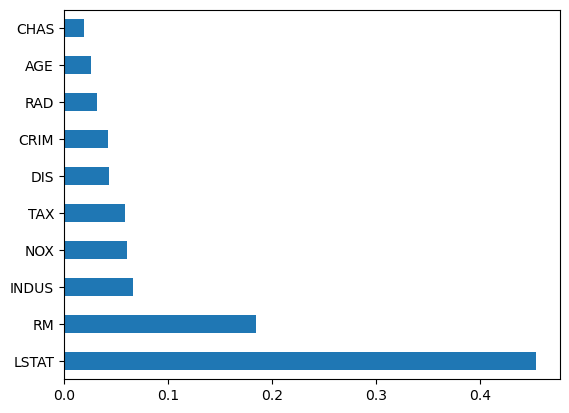

In [19]:
rank = pd.Series(ext.feature_importances_, index=X.columns)
rank.nlargest(10).plot(kind='barh')

## Top 5 important features (according to Extra trees Classifier) are - 

1. LSTAT   
2. RM      
3. NOX     
4. TAX 
5. INDUS

# Checking regression plot for few correlated features (+ve and -ve)

<AxesSubplot:xlabel='CRIM', ylabel='Price'>

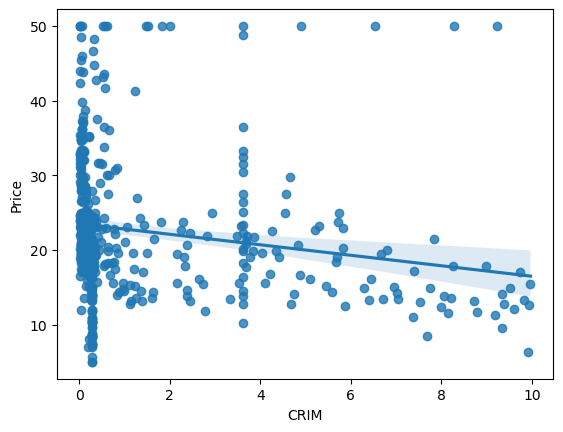

In [20]:
sns.regplot(x ="CRIM",y="Price",data=df) # -ve correlation

<AxesSubplot:xlabel='RM', ylabel='Price'>

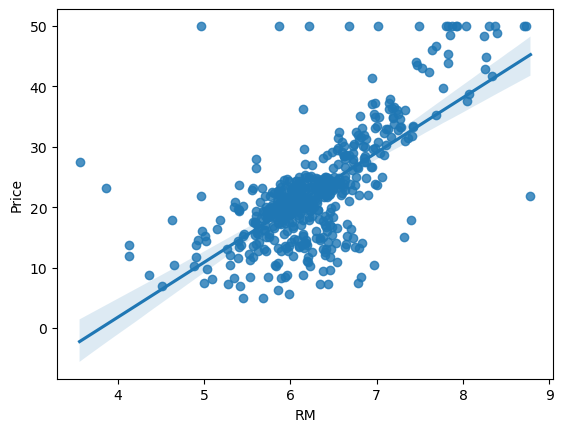

In [24]:
sns.regplot(x ="RM",y="Price",data=df) # +ve correlation

## Checking multi-collinearity

In [21]:
VIF = pd.DataFrame()

In [22]:
Xcopy = X.copy()
ycopy = y.copy()

In [23]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xcopy,ycopy,test_size=0.3,random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(354, 13) (152, 13) (354,) (152,)


In [24]:
std = StandardScaler()

Xtrain = std.fit_transform(Xtrain,ytrain)
Xtest = std.transform(Xtest)

In [25]:
VIF['vif'] = [variance_inflation_factor(Xtrain,i) for i in range(Xtrain.shape[1])]

In [26]:
VIF['columns'] = Xcopy.columns

In [27]:
VIF

,vif,columns
0,1.74,CRIM
1,1.27,ZN
2,3.28,INDUS
3,1.07,CHAS
4,4.25,NOX
5,1.44,RM
6,2.62,AGE
7,3.51,DIS
8,6.83,RAD
9,8.48,TAX


# Only RAD and TAX are above 5. Therefore, can drop any one 1 column. 

In [28]:
X.drop(columns=['TAX'], inplace=True)

In [29]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1,19.10,391.43,4.98
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2,19.10,391.43,9.14
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2,19.10,391.43,4.03
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3,19.10,391.43,2.94
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3,19.10,391.43,12.72
...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06,0.00,11.93,0.00,0.57,6.59,69.10,2.48,1,19.10,391.43,12.72
502,0.05,0.00,11.93,0.00,0.57,6.12,76.70,2.29,1,19.10,391.43,9.08
503,0.06,0.00,11.93,0.00,0.57,6.98,91.00,2.17,1,19.10,391.43,5.64
504,0.11,0.00,11.93,0.00,0.57,6.79,89.30,2.39,1,19.10,391.43,6.48


# MODEL BUILDING

In [59]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,train_size=0.75, random_state=42)

In [60]:
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(379, 13) (127, 13) (379,) (127,)


In [61]:
std = StandardScaler()

Xtrain = std.fit_transform(Xtrain,ytrain)
Xtest = std.transform(Xtest)

In [33]:
pickle.dump(std,open('scaling.pkl','wb'))

In [34]:
models,predictions = LazyRegressor().fit(Xtrain, Xtest, ytrain, ytest)

100%|██████████| 42/42 [00:32<00:00,  1.28it/s]


In [35]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.77,0.79,3.86,0.94
XGBRegressor,0.76,0.79,3.87,0.81
GradientBoostingRegressor,0.74,0.77,4.02,0.91
BaggingRegressor,0.74,0.77,4.06,0.17
ExtraTreesRegressor,0.73,0.76,4.10,1.11
HistGradientBoostingRegressor,0.72,0.75,4.20,6.88
LGBMRegressor,0.71,0.73,4.32,0.30
AdaBoostRegressor,0.68,0.71,4.53,0.84
DecisionTreeRegressor,0.61,0.65,4.95,0.03


# Without hyperparameter tuning

In [64]:
rf = RandomForestRegressor()

rf.fit(Xtrain,ytrain)
predict = rf.predict(Xtest)

In [65]:
mean_absolute_error(ytest, predict)

2.424055118110237

In [66]:
mean_squared_error(ytest, predict)

15.617771330708665

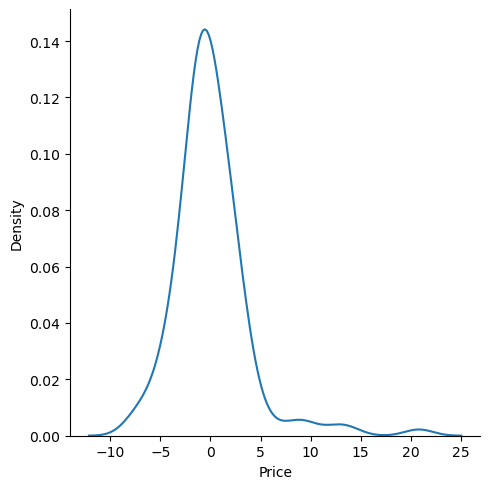

In [39]:
residual = ytest-predict
sns.displot(residual, kind='kde')

In [40]:
# coefficient of determination
r2_score(ytest, predict)

0.8029853274090684

In [41]:
# Formula : Adj r2 = 1-(1-r2)*((n-1)/(n-p-1))
# r2 = sample R2 (or score)
# n = total sample size
# p = no. of predictors
#function to create adjusted r2

def adj_r2(a,b):
    r2 = r2_score(a,b)
    n = len(a)
    p = Xtest.shape[1]
    adjusted_r2 = 1-((1-r2)*(n-1))/(n-p-1)
    print(adjusted_r2)
    

In [42]:
adj_r2(ytest,predict) #has to be lesser than r2

0.7822469408205492


In [67]:
rf_train_scores = cross_val_score(rf, Xtrain,ytrain, scoring='r2', cv = KFold(5))
rf_train_scores

array([0.79805428, 0.75228387, 0.83791696, 0.72584819, 0.58453798])

In [68]:
rf_train_scores.mean()

0.7397282584113979

In [69]:
rf_test_scores = cross_val_score(rf, Xtest,ytest, scoring='r2', cv = KFold(5))
rf_test_scores

array([0.76284992, 0.81236311, 0.72764314, 0.37670055, 0.60472361])

In [70]:
rf_test_scores.mean()

0.6568560652709772

# Hyperparameter Tuning

In [47]:
cv = KFold(5)

In [48]:
params = { 'n_estimators' : [100, 150, 200, 250, 300, 400], 
             'criterion' : ['squared_error', 'absolute_error', 'poisson'], 
             'max_depth' : range(2, 40, 1), 
             'min_samples_split' : range(2, 40, 1), 
             'min_samples_leaf' : range(2, 40, 1), 
             'max_features' : ['sqrt', 'log2'],
          'max_leaf_nodes' : range(2, 40)
             }

In [49]:
tune = RandomizedSearchCV(rf, params, cv = cv, n_jobs=-1, verbose=3)

In [50]:
tune.fit(Xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': range(2, 40),
                                        'max_features': ['sqrt', 'log2'],
                                        'max_leaf_nodes': range(2, 40),
                                        'min_samples_leaf': range(2, 40),
                                        'min_samples_split': range(2, 40),
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 400]},
                   verbose=3)

In [51]:
tune.best_estimator_

RandomForestRegressor(criterion='poisson', max_depth=34, max_features='sqrt',
                      max_leaf_nodes=34, min_samples_leaf=13,
                      min_samples_split=5, n_estimators=250)

In [52]:
new_rf = RandomForestRegressor(criterion='poisson', max_depth=34, max_features='sqrt',
                      max_leaf_nodes=34, min_samples_leaf=13,
                      min_samples_split=5, n_estimators=250)

In [53]:
new_rf.fit(Xtrain, ytrain)
predict = new_rf.predict(Xtest)

In [54]:
mean_absolute_error(ytest, predict)

3.427333577304168

In [55]:
mean_squared_error(ytest, predict)

25.890168372049477

In [56]:
r2_score(ytest, predict)

0.6302838153750058

In [57]:
adj_r2(ytest, predict)

0.5913663222565854


### Trying LightGBM because it is not included in LazyRegressor

In [56]:
lgbm = lightgbm.LGBMRegressor()

In [71]:
lgbm_train_scores = cross_val_score(lgbm,Xtrain,ytrain,scoring='r2',cv = KFold(5))
print(lgbm_train_scores, '\n', lgbm_train_scores.mean())

[0.78374262 0.78834442 0.87551057 0.76661618 0.65252741] 
 0.7733482386428866


In [72]:
lgbm_test_scores = cross_val_score(lgbm,Xtest,ytest,scoring='r2',cv = KFold(5))
print(lgbm_test_scores, '\n', lgbm_test_scores.mean())

[0.66715253 0.56183162 0.66172699 0.42366079 0.42408658] 
 0.547691701619236


In [75]:
rf_test_scores.mean(), lgbm_test_scores.mean()

(0.6568560652709772, 0.547691701619236)

### Even with hyper-paramter optimization, r2 score of base model achieves higher results. 

### Hyperparamters can be tuned more efficiently by adding or removing few parameters. 

### For now, let us consider base model.

# New Data Prediction - prediction of single data point instead of bulk

In [317]:
to_predict = df.iloc[:1,:-1]

In [319]:
to_predict.drop(columns=['TAX'], inplace=True)
to_predict

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1,19.10,391.43,4.98


## Standardization will not matter because we are using Random Forest

In [320]:
rf.predict(to_predict)

array([28.523])

In [321]:
df[:1] #Price = 28; very close; good model

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1,296,19.10,391.43,4.98,24.00


# Pickle for Deployment

In [58]:
pickle.dump(rf,open('regmodel.pkl','wb'))

In [324]:
#checking the pickle file
model = pickle.load(open('regmodel.pkl','rb'))
model.predict(to_predict)

array([28.523])